## General information

In this kernel I'll try various technics for models interpretability and feature selection. Also I'll compare various models.

I use the features from my dataset: https://www.kaggle.com/artgor/lanl-features

This dataset was created using this kernel: https://www.kaggle.com/artgor/even-more-features/

**UPD**: Thanks to the new kaggle update we can write code in kernels and import it. This is much more convenient and useful.
I'm moving all the functions I can into this script: https://www.kaggle.com/artgor/artgor-utils
So if you see somewhere code like `artgot_utils.function_name(parameters)` - it is from this script

![](https://torontoseoulcialite.com/wp-content/uploads/2016/02/zimbiocom.jpg)

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import NearestNeighbors
import librosa, librosa.display
import builtins
from sklearn.ensemble import RandomForestRegressor
import eli5
import shap
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE

from IPython.display import HTML
import json
import altair as alt

import artgor_utils

# setting up altair
workaround = artgor_utils.prepare_altair()
HTML("".join((
    "<script>",
    workaround,
    "</script>",
)))

In [2]:
os.listdir('../input/lanl-features')

['test_features_denoised.csv',
 'submission_1.csv',
 'train_features_denoised.csv',
 'train_features.csv',
 'y.csv',
 'test_features.csv']

* 'train_features.csv' - train features generated on original data
* 'train_features_denoised.csv' - train features generated on denoised data
* 'test_features.csv' - test features generated on original data
* 'test_features_denoised.csv' - test features generated on denoised data
* 'submission_1.csv' - one of my local submissions
* 'y.csv' - train target

## Loading data
Let's load features!

In [3]:
train_features = pd.read_csv('../input/lanl-features/train_features.csv')
test_features = pd.read_csv('../input/lanl-features/test_features.csv')
train_features_denoised = pd.read_csv('../input/lanl-features/train_features_denoised.csv')
test_features_denoised = pd.read_csv('../input/lanl-features/test_features_denoised.csv')
train_features_denoised.columns = [f'{i}_denoised' for i in train_features_denoised.columns]
test_features_denoised.columns = [f'{i}_denoised' for i in test_features_denoised.columns]
y = pd.read_csv('../input/lanl-features/y.csv')

In [4]:
X = pd.concat([train_features, train_features_denoised], axis=1).drop(['seg_id_denoised', 'target_denoised'], axis=1)
X_test = pd.concat([test_features, test_features_denoised], axis=1).drop(['seg_id_denoised', 'target_denoised'], axis=1)
X = X[:-1]
y = y[:-1]

We have almost 2000 features here!

In [5]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

## Basic model

Training function is imported from my script. Important changes from the code, which I used previously:
- function returns dictionary with oof, test predictions and scores. Also with feature importances, if necessary;
- in future it will be easier to change metrics.

Fold 1 started at Mon May  6 15:30:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[721]	training's l1: 1.19113	valid_1's l1: 2.09677
Fold 2 started at Mon May  6 15:30:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[922]	training's l1: 1.05378	valid_1's l1: 2.01019
Fold 3 started at Mon May  6 15:30:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[479]	training's l1: 1.40943	valid_1's l1: 2.15207
Fold 4 started at Mon May  6 15:30:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[488]	training's l1: 1.43212	valid_1's l1: 1.93879
Fold 5 started at Mon May  6 15:31:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[428]	training's l1: 1.46909	valid_1's l1: 2.07096
CV mean score: 2.0538, std: 0.0734.


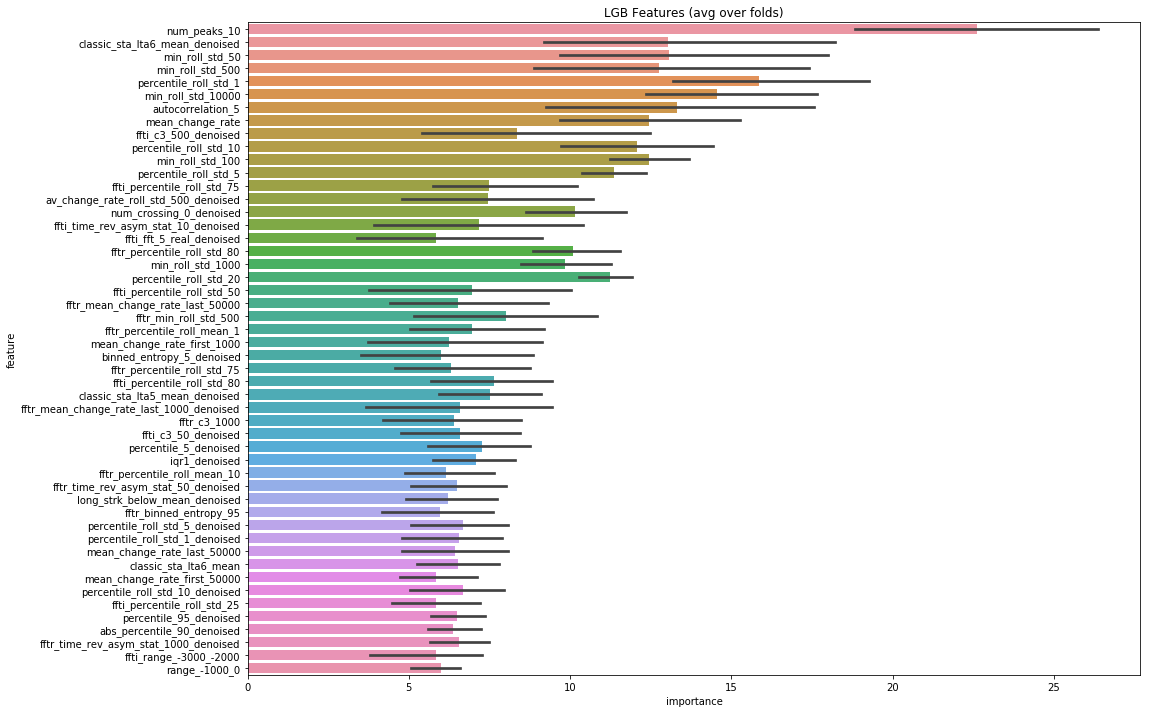

In [6]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "subsample_freq": 5,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'colsample_bytree': 0.1
         }
result_dict_lgb = artgor_utils.train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb',
                                                                                  eval_metric='mae', plot_feature_importance=True)

In [7]:
submission = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = result_dict_lgb['prediction']
print(submission.head())
submission.to_csv('submission.csv')

              time_to_failure
seg_id                       
seg_00030f  3.731945702115927
seg_0012b5  4.699451914539027
seg_00184e  5.442901941932413
seg_003339  8.587579186887865
seg_0042cc  6.958036833658971


In [8]:
sub1 = pd.read_csv('../input/lanl-features/submission_1.csv')
sub1.to_csv('submission_1.csv', index=False)

## NN features
Here I normalize the data and create features using NearestNeighbors. The idea is to find samples which are similar and use it to generate features.

In [9]:
scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [10]:
%%time
n = 10
neigh = NearestNeighbors(n, n_jobs=-1)
neigh.fit(X_train_scaled)

dists, _ = neigh.kneighbors(X_train_scaled, n_neighbors=n)
mean_dist = dists.mean(axis=1)
max_dist = dists.max(axis=1)
min_dist = dists.min(axis=1)

X_train_scaled['mean_dist'] = mean_dist
X_train_scaled['max_dist'] = max_dist
X_train_scaled['min_dist'] = min_dist

test_dists, _ = neigh.kneighbors(X_test_scaled, n_neighbors=n)

test_mean_dist = test_dists.mean(axis=1)
test_max_dist = test_dists.max(axis=1)
test_min_dist = test_dists.min(axis=1)

X_test_scaled['mean_dist'] = test_mean_dist
X_test_scaled['max_dist'] = test_max_dist
X_test_scaled['min_dist'] = test_min_dist


CPU times: user 3min 10s, sys: 180 ms, total: 3min 11s
Wall time: 49.1 s


Fold 1 started at Mon May  6 15:32:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[735]	training's l1: 1.25005	valid_1's l1: 2.09372
Fold 2 started at Mon May  6 15:32:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[798]	training's l1: 1.21512	valid_1's l1: 2.00461
Fold 3 started at Mon May  6 15:32:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[444]	training's l1: 1.49554	valid_1's l1: 2.15212
Fold 4 started at Mon May  6 15:33:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[392]	training's l1: 1.59452	valid_1's l1: 1.94258
Fold 5 started at Mon May  6 15:33:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[489]	training's l1: 1.46327	valid_1's l1: 2.07081
CV mean score: 2.0528, std: 0.0726.


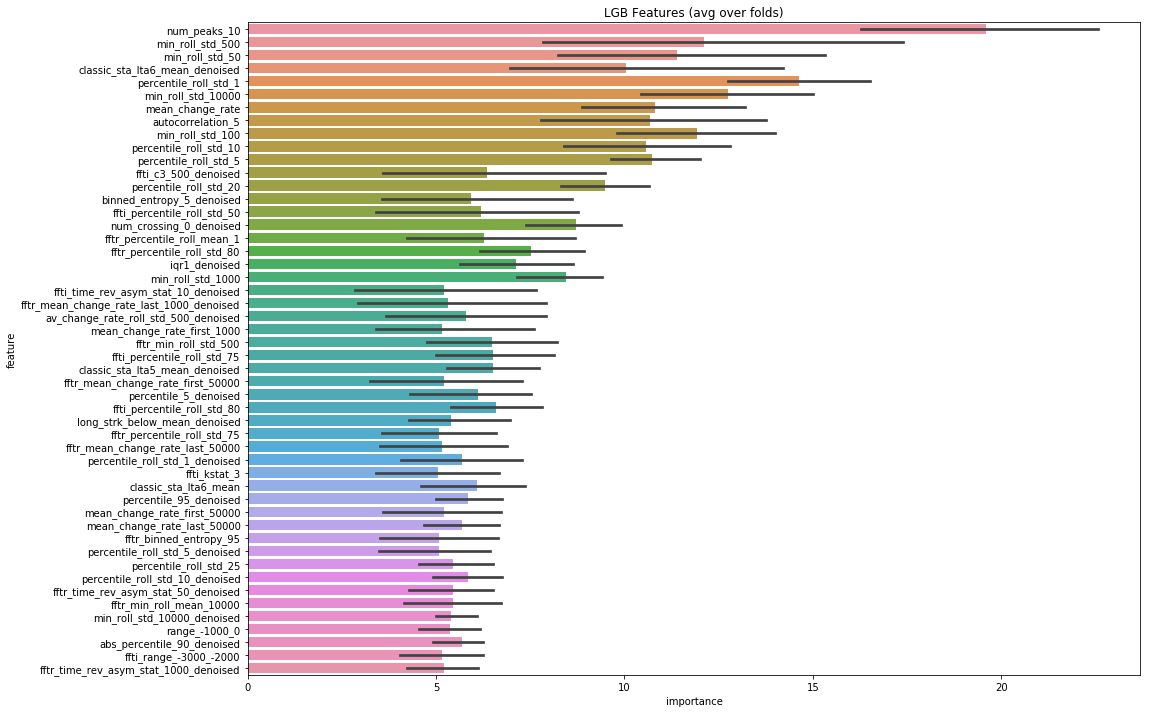

In [11]:
params = {'num_leaves': 32,
          'min_data_in_leaf': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'feature_fraction': 0.1
         }
result_dict_lgb = artgor_utils.train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb',
                                                                                  eval_metric='mae', plot_feature_importance=True)

In [12]:
submission['time_to_failure'] = result_dict_lgb['prediction']
submission.to_csv('submission_nn.csv')

## Model interpretation


### ELI5 and permutation importance
ELI5 is a package with provides explanations for ML models. It can do this not only for linear models, but also for tree based like Random Forest or lightgbm.

**Important notice**: running eli5 on all features takes a lot of time, so I run the cell below in `version 14` and printed the top-50 features. In the following versions I'll use these 50 columns and use eli5 to find top-40 of them so that it takes less time

In [13]:
top_columns = ['iqr1_denoised', 'percentile_5_denoised', 'abs_percentile_90_denoised', 'percentile_95_denoised', 'ave_roll_std_10', 'num_peaks_10', 'percentile_roll_std_20',
               'ratio_unique_values_denoised', 'fftr_percentile_roll_std_75_denoised', 'num_crossing_0_denoised', 'percentile_95', 'ffti_percentile_roll_std_75_denoised',
               'min_roll_std_10000', 'percentile_roll_std_1', 'percentile_roll_std_10', 'fftr_percentile_roll_std_70_denoised', 'ave_roll_std_50', 'ffti_percentile_roll_std_70_denoised',
               'exp_Moving_std_300_mean_denoised', 'ffti_percentile_roll_std_30_denoised', 'mean_change_rate', 'percentile_roll_std_5', 'range_-1000_0', 'mad',
               'fftr_range_1000_2000_denoised', 'percentile_10_denoised', 'ffti_percentile_roll_std_80', 'percentile_roll_std_25', 'fftr_percentile_10_denoised',
               'ffti_range_-2000_-1000_denoised', 'autocorrelation_5', 'min_roll_std_100', 'fftr_percentile_roll_std_80', 'min_roll_std_500', 'min_roll_std_50', 'min_roll_std_1000',
               'ffti_percentile_20_denoised', 'iqr1', 'classic_sta_lta5_mean_denoised', 'classic_sta_lta6_mean_denoised', 'percentile_roll_std_10_denoised',
               'fftr_percentile_70_denoised', 'ffti_c3_50_denoised', 'ffti_percentile_roll_std_75', 'abs_percentile_90', 'range_0_1000', 'spkt_welch_density_50_denoised',
               'ffti_percentile_roll_std_40_denoised', 'ffti_range_-4000_-3000', 'mean_change_rate_last_50000']


X_train, X_valid, y_train, y_valid = train_test_split(X[top_columns], y, test_size=0.1)
model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1, verbose=-1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
        verbose=10000, early_stopping_rounds=200)

perm = eli5.sklearn.PermutationImportance(model, random_state=1).fit(X_train, y_train)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[747]	training's l1: 1.68657	valid_1's l1: 2.18869


In [14]:
eli5.show_weights(perm, top=50, feature_names=top_columns)

Weight,Feature
0.0439 ± 0.0045,num_crossing_0_denoised
0.0247 ± 0.0052,num_peaks_10
0.0192 ± 0.0021,percentile_roll_std_5
0.0166 ± 0.0025,abs_percentile_90_denoised
0.0157 ± 0.0004,percentile_95_denoised
0.0154 ± 0.0018,percentile_5_denoised
0.0148 ± 0.0027,percentile_roll_std_1
0.0143 ± 0.0021,min_roll_std_10000
0.0142 ± 0.0018,percentile_roll_std_10
0.0140 ± 0.0017,min_roll_std_100


Fold 1 started at Mon May  6 15:34:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[528]	training's l1: 1.81045	valid_1's l1: 2.12571
Fold 2 started at Mon May  6 15:34:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[756]	training's l1: 1.74081	valid_1's l1: 2.02542
Fold 3 started at Mon May  6 15:34:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[900]	training's l1: 1.66609	valid_1's l1: 2.16035
Fold 4 started at Mon May  6 15:34:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[419]	training's l1: 1.89397	valid_1's l1: 1.95057
Fold 5 started at Mon May  6 15:34:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[409]	training's l1: 1.85917	valid_1's l1: 2.11943
CV mean score: 2.0763, std: 0.0771.


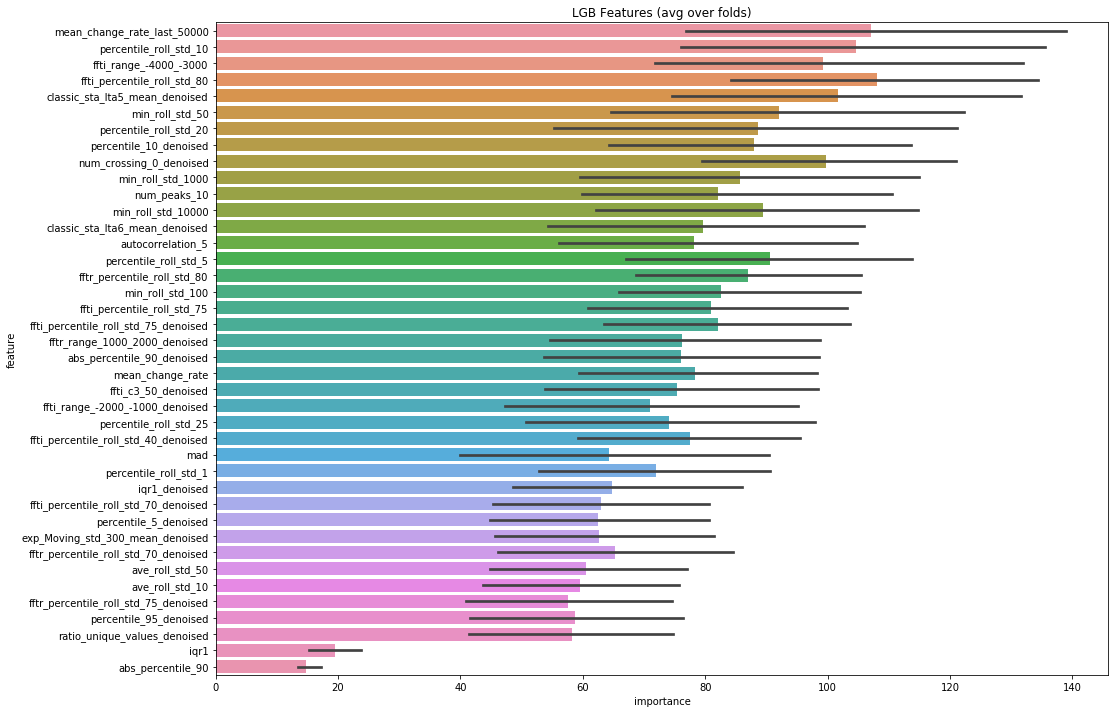

In [15]:
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:40]
result_dict_lgb = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True, columns=top_features)

In [16]:
submission['time_to_failure'] = result_dict_lgb['prediction']
submission.to_csv('submission_eli5.csv')

## Feature selection

Here I try various approaches to feature selection.

**Important notice**: running feature selection on all features takes a lot of time, so I'll run some of feature selection methods and print the result, which I'll use in the following versions of the kernel, so that I can explore more approaches.

In [17]:
params = {'num_leaves': 32,
          'min_child_samples': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "subsample_freq": 5,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'colsample_bytree': 1.0
         }

### SelectPercentile

**Important notice**:  I run the cell below in `version 14` and printed the scores_dict. In the following versions I'll use `scores_dict` and plot the results instead of running feature selection each time

In [18]:
# %%time
# scores_dict = {'f_classif': [], 'mutual_info_classif': [], 'n_features': []}
# for i in range(5, 105, 5):
#     print(i)
#     s1 = SelectPercentile(f_classif, percentile=i)
#     X_train1 = s1.fit_transform(X, y.values.astype(int))
#     X_test1 = s1.transform(X_test)
#     result_dict_lgb = artgor_utils.train_model_regression(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['f_classif'].append(np.mean(result_dict_lgb['scores']))
    
#     s2 = SelectPercentile(mutual_info_classif, percentile=i)
#     X_train1 = s2.fit_transform(X, y.values.astype(int))
#     X_test1 = s2.transform(X_test)
#     result_dict_lgb = artgor_utils.train_model_regression(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['mutual_info_classif'].append(np.mean(result_dict_lgb['scores']))
    
#     scores_dict['n_features'].append(X_train1.shape[1])

In [19]:
scores_dict = {'f_classif': [2.0746468465171377, 2.0753843541953687, 2.062191535440333, 2.0654327826583034, 2.0643551320704936, 2.0617560048382675,
                             2.061565197738015, 2.0598878198917494, 2.0654865223333143, 2.0632788555735777, 2.058002635080971, 2.051075689018734,
                             2.0472543961304583, 2.052401474353084, 2.055924154798443, 2.0561794619762352, 2.0549680611994963, 2.057123777802326,
                             2.0591868861136904, 2.0577745274024553],
               'mutual_info_classif': [2.0866763775014006, 2.0745431497064324, 2.0564324832516427, 2.060125564781158, 2.067334544167612, 2.0665943783246448,
                                       2.063891669849029, 2.070194051004794, 2.0667490707700447, 2.0681653852378354, 2.0592743636982345, 2.061260741522344,
                                       2.05680667824411, 2.0565047875243003, 2.058252567141659, 2.0554927194831922, 2.0562776429736873, 2.0618179277444084,
                                       2.06364125584214, 2.0577745274024553],
               'n_features': [98, 196, 294, 392, 490, 588, 685, 783, 881, 979, 1077, 1175, 1273, 1370, 1468, 1566, 1664, 1762, 1860, 1958]}

In [20]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['mutual_info_classif', 'f_classif'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.05
min_value = scores_df['mae'].min() * 0.95
artgor_utils.render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by SelectPercentile vs CV'
).interactive())

### SelectKBest

**Important notice**:  I run the cell below in `version 14` and printed the scores_dict. In the following versions I'll use `scores_dict` and plot the results instead of running feature selection each time

In [21]:
# %%time
# scores_dict = {'f_classif': [], 'mutual_info_classif': [], 'n_features': []}
# for i in np.arange(10, 1958, 100):
#     print(i)
#     s1 = SelectKBest(f_classif, k=i)
#     X_train1 = s1.fit_transform(X, y.values.astype(int))
#     X_test1 = s1.transform(X_test)
#     result_dict_lgb = artgor_utils.train_model_regression(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['f_classif'].append(np.mean(result_dict_lgb['scores']))
    
#     s2 = SelectKBest(mutual_info_classif, k=i)
#     X_train1 = s2.fit_transform(X, y.values.astype(int))
#     X_test1 = s2.transform(X_test)
#     result_dict_lgb = artgor_utils.train_model_regression(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['mutual_info_classif'].append(np.mean(result_dict_lgb['scores']))
    
#     scores_dict['n_features'].append(X_train1.shape[1])

In [22]:
scores_dict = {'f_classif': [2.1495892622081354, 2.0778182269587147, 2.0716153738740006, 2.06152950679902, 2.0645162758752553, 2.0627705797004032, 2.0610992303725157,
                             2.057762113735462, 2.0618360883613627, 2.0603197111525984, 2.06081274633874, 2.0580767195278056, 2.0527646572747127, 2.0498353445032533,
                             2.052442594925, 2.0564456881902133, 2.0582284644115365, 2.0558612960548635, 2.0580900016350094, 2.058218782401599],
               'mutual_info_classif': [2.1235703196243687, 2.084958198672301, 2.0596822478390955, 2.053305869981444, 2.063468853227225, 2.0674399950434323, 2.0658618511287874,
                                       2.063003703200445, 2.0653174905858664, 2.0644340327023656, 2.0748993062333523, 2.0587602096358113, 2.0601495560836076, 2.0559629138548603,
                                       2.0553852701221134, 2.058022171415446, 2.060755947658241, 2.057916705462307, 2.056245795262636, 2.0580691870837056],
               'n_features': [10, 110, 210, 310, 410, 510, 610, 710, 810, 910, 1010, 1110, 1210, 1310, 1410, 1510, 1610, 1710, 1810, 1910]}

In [23]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['mutual_info_classif', 'f_classif'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.05
min_value = scores_df['mae'].min() * 0.95
artgor_utils.render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by SelectKBest vs CV'
).interactive())

### Dropping highly correlated features

Due to the huge number of features there are certainly some highly correlated features, let's try droping them!

Fold 1 started at Mon May  6 15:34:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[432]	training's l1: 1.34605	valid_1's l1: 2.09573
Fold 2 started at Mon May  6 15:35:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[531]	training's l1: 1.2392	valid_1's l1: 1.99911
Fold 3 started at Mon May  6 15:36:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[295]	training's l1: 1.52249	valid_1's l1: 2.16609
Fold 4 started at Mon May  6 15:36:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[242]	training's l1: 1.64763	valid_1's l1: 1.933
Fold 5 started at Mon May  6 15:37:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[440]	training's l1: 1.33971	valid_1's l1: 2.06984
CV mean score: 2.0528, std: 0.0803.


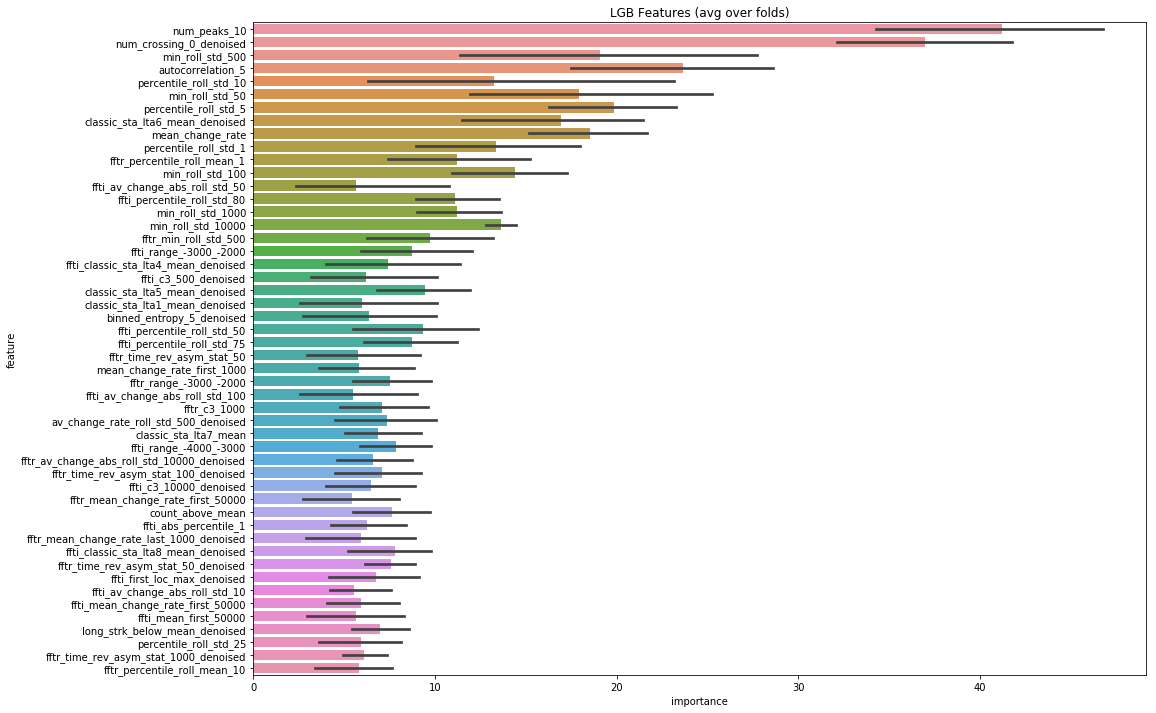

In [24]:
# https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
X = X.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)
result_dict_lgb_lgb = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [25]:
submission['time_to_failure'] = result_dict_lgb['prediction']
submission.to_csv('submission_no_corr.csv')

**Important**: from now I'll use the reduced dataset - without highly correlated features.

### RFE


**Important notice**:  I run the cell below in `version 18` and printed the scores_dict. In the following versions I'll use `scores_dict` and plot the results instead of running feature selection each time

In [26]:
# %%time
# scores_dict = {'rfe_score': [], 'n_features': []}
# for i in np.arange(10, 1958, 100)[:3]:
#     print(i)
#     s1 = RFE(model, i, step=100)
#     X_train1 = s1.fit_transform(X, y.values.astype(int))
#     X_test1 = s1.transform(X_test)
#     result_dict_lgb = artgor_utils.train_model_regression(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['rfe_score'].append(np.mean(result_dict_lgb['scores']))
    
#     scores_dict['n_features'].append(X_train1.shape[1])

In [27]:
scores_dict = {'rfe_score': [2.103586938061856, 2.052535910798748, 2.053228199447811], 'n_features': [10, 110, 210]}

In [28]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['rfe_score'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.05
min_value = scores_df['mae'].min() * 0.95
artgor_utils.render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by RFE vs CV'
).interactive())

## Model comparison

In this section I'll try variuos sklearn models and compair their score. Running GridSearchCV each time is too long, so I'll run it once for each model and use optimal parameters.

In [29]:
%%time
rfr = RandomForestRegressor()

# parameter_grid = {'n_estimators': [50, 60],
#                   'max_depth': [5, 10]
#                  }

# grid_search = GridSearchCV(rfr, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
# grid_search.fit(X, y)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))
# rfr = RandomForestRegressor(**grid_search.best_params_)
rfr = RandomForestRegressor(n_estimators=50, max_depth=5)
result_dict_rfr = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=rfr)
# print(scores_rfr)

Fold 1 started at Mon May  6 15:38:08 2019
Fold 0. mae: 2.1427.

Fold 2 started at Mon May  6 15:38:51 2019
Fold 1. mae: 2.1004.

Fold 3 started at Mon May  6 15:39:34 2019
Fold 2. mae: 2.1895.

Fold 4 started at Mon May  6 15:40:16 2019
Fold 3. mae: 1.9814.

Fold 5 started at Mon May  6 15:40:59 2019
Fold 4. mae: 2.1074.

CV mean score: 2.1043, std: 0.0691.
CPU times: user 3min 33s, sys: 616 ms, total: 3min 33s
Wall time: 3min 33s


In [30]:
%%time
linreg = linear_model.LinearRegression(normalize=False, copy_X=True, n_jobs=-1)

result_dict_linreg = artgor_utils.train_model_regression(X, X_test, y, params=None, folds=folds, model_type='sklearn', model=linreg)
# print(scores_linreg)

Fold 1 started at Mon May  6 15:41:42 2019
Fold 0. mae: 4.2884.

Fold 2 started at Mon May  6 15:41:43 2019
Fold 1. mae: 5.3284.

Fold 3 started at Mon May  6 15:41:44 2019
Fold 2. mae: 4.4585.

Fold 4 started at Mon May  6 15:41:45 2019
Fold 3. mae: 3.0664.

Fold 5 started at Mon May  6 15:41:46 2019
Fold 4. mae: 9.3260.

CV mean score: 5.2935, std: 2.1415.
CPU times: user 6.53 s, sys: 3.43 s, total: 9.96 s
Wall time: 4.93 s


In [31]:
%%time
ridge = linear_model.Ridge(normalize=True)

parameter_grid = {'alpha': [0.1, 1.0, 10.0]}

grid_search = GridSearchCV(ridge, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
ridge = linear_model.Ridge(**grid_search.best_params_, normalize=True)
result_dict_ridge = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=ridge)
# print(scores_ridge)

Best score: -2.148000446396182
Best parameters: {'alpha': 1.0}
Fold 1 started at Mon May  6 15:41:59 2019
Fold 0. mae: 2.1765.

Fold 2 started at Mon May  6 15:42:00 2019
Fold 1. mae: 2.1246.

Fold 3 started at Mon May  6 15:42:01 2019
Fold 2. mae: 2.2160.

Fold 4 started at Mon May  6 15:42:01 2019
Fold 3. mae: 2.0088.

Fold 5 started at Mon May  6 15:42:02 2019
Fold 4. mae: 2.2141.

CV mean score: 2.1480, std: 0.0771.
CPU times: user 5.87 s, sys: 5.42 s, total: 11.3 s
Wall time: 16.2 s


In [32]:
%%time
knn = neighbors.KNeighborsRegressor()

parameter_grid = {'n_neighbors': [50, 100]}

grid_search = GridSearchCV(knn, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
knn = neighbors.KNeighborsRegressor(**grid_search.best_params_)
result_dict_knn = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=knn)

Best score: -2.386296024679084
Best parameters: {'n_neighbors': 100}
Fold 1 started at Mon May  6 15:42:15 2019
Fold 0. mae: 2.4430.

Fold 2 started at Mon May  6 15:42:17 2019
Fold 1. mae: 2.3574.

Fold 3 started at Mon May  6 15:42:20 2019
Fold 2. mae: 2.4659.

Fold 4 started at Mon May  6 15:42:23 2019
Fold 3. mae: 2.2854.

Fold 5 started at Mon May  6 15:42:25 2019
Fold 4. mae: 2.3797.

CV mean score: 2.3863, std: 0.0642.
CPU times: user 13.5 s, sys: 824 ms, total: 14.3 s
Wall time: 25.1 s


In [33]:
%%time
lasso = linear_model.Lasso(normalize=True)

parameter_grid = {'alpha': [0.1, 1.0, 10.0]}

grid_search = GridSearchCV(lasso, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
lasso = linear_model.Lasso(**grid_search.best_params_, normalize=True)
result_dict_lasso = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=lasso)

Best score: -3.048578606466069
Best parameters: {'alpha': 0.1}
Fold 1 started at Mon May  6 15:42:34 2019
Fold 0. mae: 3.1293.

Fold 2 started at Mon May  6 15:42:35 2019
Fold 1. mae: 3.1061.

Fold 3 started at Mon May  6 15:42:36 2019
Fold 2. mae: 3.0267.

Fold 4 started at Mon May  6 15:42:36 2019
Fold 3. mae: 2.9735.

Fold 5 started at Mon May  6 15:42:37 2019
Fold 4. mae: 3.0073.

CV mean score: 3.0486, std: 0.0594.
CPU times: user 4.24 s, sys: 3.3 s, total: 7.55 s
Wall time: 9.65 s


In [34]:
%%time
etr = ExtraTreesRegressor()

# parameter_grid = {'n_estimators': [500, 1000],
#                   'max_depth': [5, 10, 20]
#                  }

# grid_search = GridSearchCV(rfr, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
# grid_search.fit(X, y)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))
# etr = ExtraTreesRegressor(**grid_search.best_params_)
etr = ExtraTreesRegressor(n_estimators=1000, max_depth=10)
result_dict_etr = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=etr)

Fold 1 started at Mon May  6 15:42:38 2019
Fold 0. mae: 2.1509.

Fold 2 started at Mon May  6 15:47:49 2019
Fold 1. mae: 2.0777.

Fold 3 started at Mon May  6 15:52:50 2019
Fold 2. mae: 2.1702.

Fold 4 started at Mon May  6 15:57:55 2019
Fold 3. mae: 1.9957.

Fold 5 started at Mon May  6 16:02:48 2019
Fold 4. mae: 2.0850.

CV mean score: 2.0959, std: 0.0617.
CPU times: user 24min 58s, sys: 1.1 s, total: 24min 59s
Wall time: 24min 59s


In [35]:
%%time
adr = AdaBoostRegressor()

parameter_grid = {'n_estimators': [10, 50],
                 }

grid_search = GridSearchCV(adr, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
adr = AdaBoostRegressor(**grid_search.best_params_)
result_dict_adr = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=adr)

Best score: -2.2135253394383416
Best parameters: {'n_estimators': 10}
Fold 1 started at Mon May  6 16:09:25 2019
Fold 0. mae: 2.2679.

Fold 2 started at Mon May  6 16:09:34 2019
Fold 1. mae: 2.1918.

Fold 3 started at Mon May  6 16:09:43 2019
Fold 2. mae: 2.2315.

Fold 4 started at Mon May  6 16:09:52 2019
Fold 3. mae: 2.1239.

Fold 5 started at Mon May  6 16:10:02 2019
Fold 4. mae: 2.2052.

CV mean score: 2.2041, std: 0.0478.
CPU times: user 56.8 s, sys: 732 ms, total: 57.5 s
Wall time: 2min 33s


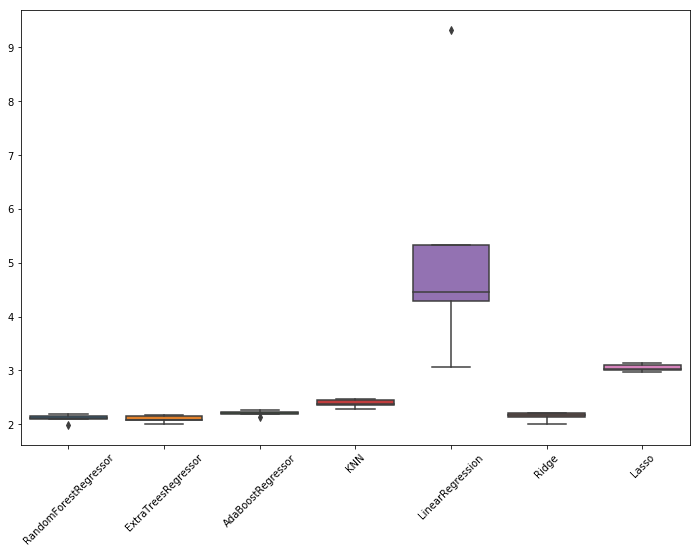

In [36]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame({'RandomForestRegressor': result_dict_rfr['scores']})
scores_df['ExtraTreesRegressor'] = result_dict_etr['scores']
scores_df['AdaBoostRegressor'] = result_dict_adr['scores']
scores_df['KNN'] = result_dict_knn['scores']
scores_df['LinearRegression'] = result_dict_linreg['scores']
scores_df['Ridge'] = result_dict_ridge['scores']
scores_df['Lasso'] = result_dict_lasso['scores']

sns.boxplot(data=scores_df);
plt.xticks(rotation=45);

## Blending

Let's try training and blending several models.

Fold 1 started at Mon May  6 16:10:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[515]	training's l1: 1.34903	valid_1's l1: 2.09009
Fold 2 started at Mon May  6 16:10:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[918]	training's l1: 1.01667	valid_1's l1: 1.99457
Fold 3 started at Mon May  6 16:10:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[488]	training's l1: 1.36924	valid_1's l1: 2.15228
Fold 4 started at Mon May  6 16:10:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[307]	training's l1: 1.62032	valid_1's l1: 1.94133
Fold 5 started at Mon May  6 16:11:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[442]	training's l1: 1.42856	valid_1's l1: 2.07431
CV mean score: 2.0505, std: 0.0742.


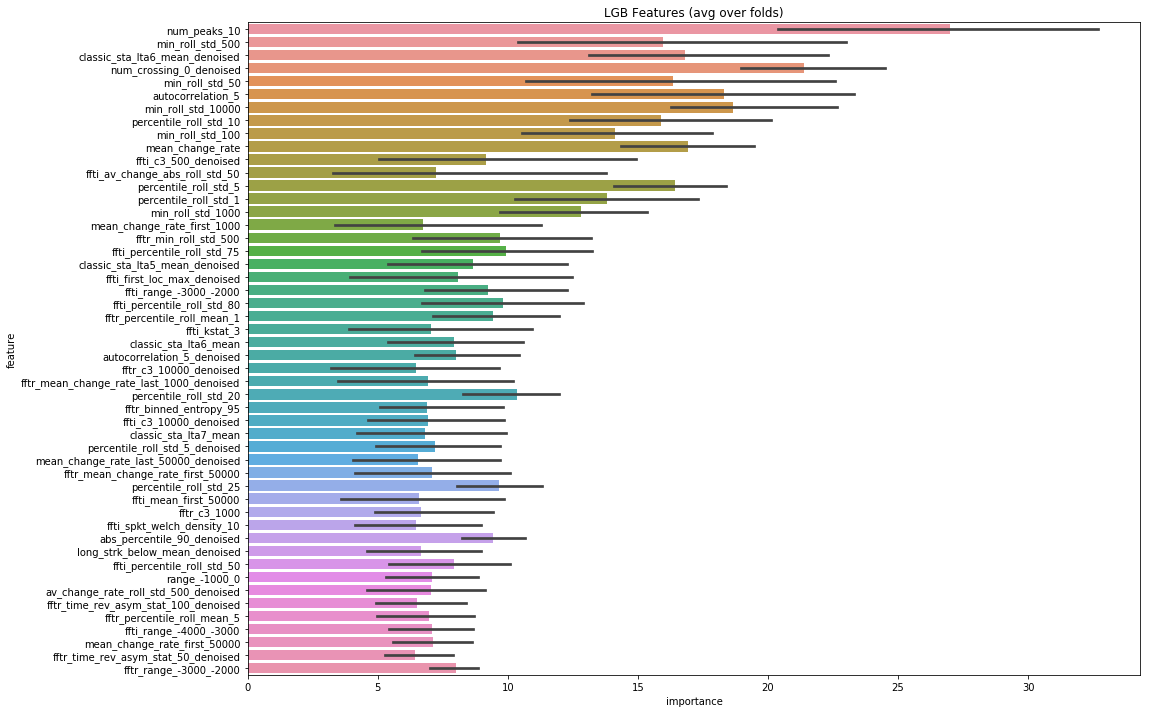

In [37]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "subsample_freq": 5,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'colsample_bytree': 0.2
         }
result_dict_lgb = artgor_utils.train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb',
                                                                                  eval_metric='mae', plot_feature_importance=True)

In [38]:
xgb_params = {'eta': 0.03,
              'max_depth': 9,
              'subsample': 0.85,
              'colsample_bytree': 0.3,
              'objective': 'reg:linear',
              'eval_metric': 'mae',
              'silent': True,
              'nthread': -1}
result_dict_xgb = artgor_utils.train_model_regression(X=X, X_test=X_test, y=y, params=xgb_params, folds=folds, model_type='xgb')

Fold 1 started at Mon May  6 16:11:17 2019
[0]	train-mae:5.0323	valid_data-mae:5.17627
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[130]	train-mae:0.48216	valid_data-mae:2.1279

Fold 2 started at Mon May  6 16:12:31 2019
[0]	train-mae:5.05933	valid_data-mae:5.07275
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[108]	train-mae:0.605177	valid_data-mae:2.07924

Fold 3 started at Mon May  6 16:13:38 2019
[0]	train-mae:5.05151	valid_data-mae:5.10482
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[102]	train-mae:0.629945	valid_data-mae:2.17829

Fold 4 started at Mon May  6 16:14:45 2019
[0]	train

In [39]:
submission['time_to_failure'] = (result_dict_lgb['prediction'] + result_dict_etr['prediction'] + result_dict_xgb['prediction']) / 3
print(submission.head())
submission.to_csv('blending.csv')

              time_to_failure
seg_id                       
seg_00030f  4.123696824813266
seg_0012b5  5.045688875507097
seg_00184e  5.739336536594375
seg_003339  8.583783908687643
seg_0042cc  6.953695533131863


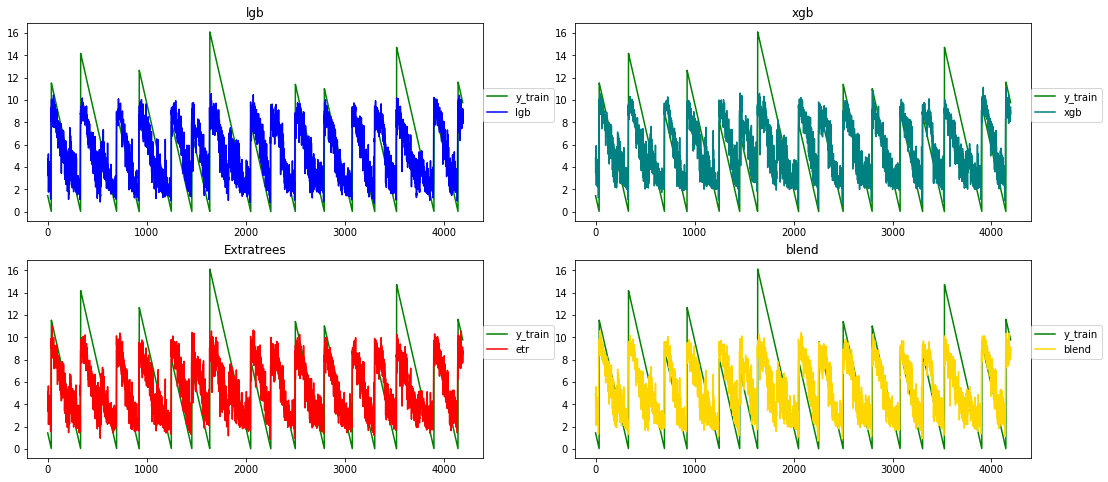

In [40]:
plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.plot(y, color='g', label='y_train')
plt.plot(result_dict_lgb['oof'], color='b', label='lgb')
plt.legend(loc=(1, 0.5));
plt.title('lgb');
plt.subplot(2, 2, 2)
plt.plot(y, color='g', label='y_train')
plt.plot(result_dict_etr['oof'], color='teal', label='xgb')
plt.legend(loc=(1, 0.5));
plt.title('xgb');
plt.subplot(2, 2, 3)
plt.plot(y, color='g', label='y_train')
plt.plot(result_dict_xgb['oof'], color='red', label='etr')
plt.legend(loc=(1, 0.5));
plt.title('Extratrees');
plt.subplot(2, 2, 4)
plt.plot(y, color='g', label='y_train')
plt.plot((result_dict_lgb['oof'] + result_dict_etr['oof'] + result_dict_xgb['oof']) / 3, color='gold', label='blend')
plt.legend(loc=(1, 0.5));
plt.title('blend');

## Stacking

In [41]:
train_stack = np.vstack([result_dict_rfr['oof'], result_dict_ridge['oof'], result_dict_knn['oof'], result_dict_lasso['oof'], result_dict_etr['oof'],
                         result_dict_adr['oof'], result_dict_lgb['oof'], result_dict_xgb['oof'], result_dict_etr['oof']]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['rfr', 'ridge', 'knn', 'lasso', 'etr', 'adr', 'lgb', 'xgb', 'etr'])

test_stack = np.vstack([result_dict_rfr['prediction'], result_dict_ridge['prediction'], result_dict_knn['prediction'], result_dict_lasso['prediction'], result_dict_etr['prediction'],
                        result_dict_adr['prediction'], result_dict_lgb['prediction'], result_dict_xgb['prediction'], result_dict_etr['prediction']]).transpose()
test_stack = pd.DataFrame(test_stack, columns=['rfr', 'ridge', 'knn', 'lasso', 'etr', 'adr', 'lgb', 'xgb', 'etr'])

In [42]:
params = {'num_leaves': 8,
         #'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 2,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
        # "lambda_l1": 0.2,
         "verbosity": -1}
result_dict_lgb_stack = artgor_utils.train_model_regression(X=train_stack, X_test=test_stack, y=y, params=params, folds=folds, model_type='lgb',
                                                                                  eval_metric='mae', plot_feature_importance=False,
                                                            columns=(list(train_stack.columns)))

Fold 1 started at Mon May  6 16:16:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[476]	training's rmse: 2.5991	training's l1: 2.02634	valid_1's rmse: 2.70716	valid_1's l1: 2.12693
Fold 2 started at Mon May  6 16:16:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[415]	training's rmse: 2.62289	training's l1: 2.05292	valid_1's rmse: 2.63967	valid_1's l1: 2.04059
Fold 3 started at Mon May  6 16:16:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[851]	training's rmse: 2.55885	training's l1: 1.98723	valid_1's rmse: 2.76484	valid_1's l1: 2.16293
Fold 4 started at Mon May  6 16:16:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[454]	training's rmse: 2.63844	training's l1: 2.06754	valid_1's rmse: 2.55267	valid_1's l1: 1.97282
Fold 5 started at Mon May  6 16:16:59

In [43]:
submission['time_to_failure'] = result_dict_lgb_stack['prediction']
print(submission.head())
submission.to_csv('stacking.csv')

              time_to_failure
seg_id                       
seg_00030f  4.390519890820985
seg_0012b5  5.221406588476073
seg_00184e  6.271068775607866
seg_003339  8.566545561557882
seg_0042cc  6.979710037607599
